In [1]:
# --- CSS STYLE ---
from IPython.core.display import HTML
def css_styling():
    styles = open("../input/2020-cost-of-living/alerts.css", "r").read()
    return HTML("<style>"+styles+"</style>")
css_styling()

<img src="https://i.imgur.com/YcUJEhW.png">

<center><h1>SIIM-FISABIO-RSNA COVID-19 Detection</h1></center>

This is **an object detection and classification problem**, meaning that for each instance we'll have to *predict* a **bounding box** and a **class**.

<div class="alert success-alert">
📌 <b>Competition Goal</b>: Categorize chest radiographs as negative for pneumonia, typical, indeterminate, or atypical for COVID-19. If some abnormalities are found, provide the bounding boxes.
</div>

OK! Covid-19 sympthoms look very similar to other viral or bacterial pneumonias/ chest radiographs, hence it's much harder to correctly (and I might add quickly) diagnose.

<div class="alert simple-alert">
🎉 <b>Fun Bonus</b>: <a href="https://www8.hp.com/us/en/workstations/overview.html">Z by HP</a> is providing the top student team with a ZBook G8 Data Science Workstation!
</div>

I have been working on these for quite some time and I absolutely LOVE it. So I encourage everybody to try, have fun and ... good luck! ❤️

### ⬇️ Libraries
* Link to my W&B Dashboard here: https://wandb.ai/andrada/siim-covid19
* How to use W&B: [Experiment Tracking with Weights and Biases](https://www.kaggle.com/ayuraj/experiment-tracking-with-weights-and-biases)

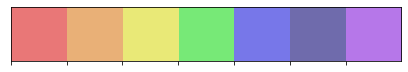

In [2]:
# Libraries
import os
import re
import wandb
import tqdm
import warnings
import glob
import ast
import cv2
import math
import pandas as pd
import numpy as np
from IPython.display import display_html
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from sklearn.cluster import KMeans
from skimage import morphology, measure

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'siim-fisabio-rsna', '_wandb_kernel': 'aot'}

# Secrets 🤫
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb")

# Custom colors
my_colors = ["#E97777", "#E9B077", "#E9E977", 
             "#77E977", "#7777E9", "#6F6BAC", "#B677E9"]
sns.palplot(sns.color_palette(my_colors))

# Set Style
sns.set_style("white")
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.rcParams.update({'font.size': 22})

class color:
    BOLD = '\033[1m' + '\033[93m'
    END = '\033[0m'

> 📌 **Note**: If this line throws an error, try using `wandb.login()` instead. It will ask for the API key to login, which you can get from your W&B profile (click on Profile -> Settings -> scroll to API keys).

In [3]:
! wandb login $secret_value_0

### ⬇️ Handy Functions

In [4]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(round(_x, 5), round(_y, 5), format(round(value, 5), ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
        
def offset_png(x, y, path, ax, zoom, offset, border=2):
    '''For adding other .png images to the graph.
    source: https://stackoverflow.com/questions/61971090/how-can-i-add-images-to-bars-in-axes-matplotlib'''
    
    img = plt.imread(path)
    im = OffsetImage(img, zoom=zoom)
    im.image.axes = ax
    x_offset = offset
    ab = AnnotationBbox(im, (x, y), xybox=(x_offset, 0), frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)
    ax.add_artist(ab)
    
    
def get_image_metadata(study_id, df):
    '''Returns the label and bounding boxes (if any)
    for a speciffic study id.'''
    
    data = df[df["study_id"] == study_id]
    
    if data["Negative for Pneumonia"].values == 1:
        label = "negative_for_pneumonia"
    elif data["Typical Appearance"].values == 1:
        label = "typical"
    elif data["Indeterminate Appearance"].values == 1:
        label = "indeterminate"
    else:
        label = "atypical"
        
    bbox = list(data["boxes"].values)
    
    return label, bbox


def save_dataset_artifact(run_name, artifact_name, path):
    '''Saves dataset to W&B Artifactory.
    run_name: name of the experiment
    artifact_name: under what name should the dataset be stored
    path: path to the dataset'''
    
    run = wandb.init(project='siim-covid19', 
                     name=run_name, 
                     config=CONFIG, anonymous="allow")
    artifact = wandb.Artifact(name=artifact_name, 
                              type='dataset')
    artifact.add_file(path)

    wandb.log_artifact(artifact)
    wandb.finish()
    print("Artifact has been saved successfully.")
    
    
def create_wandb_plot(x_data=None, y_data=None, x_name=None, y_name=None, title=None, log=None, plot="line"):
    '''Create and save lineplot/barplot in W&B Environment.
    x_data & y_data: Pandas Series containing x & y data
    x_name & y_name: strings containing axis names
    title: title of the graph
    log: string containing name of log'''
    
    data = [[label, val] for (label, val) in zip(x_data, y_data)]
    table = wandb.Table(data=data, columns = [x_name, y_name])
    
    if plot == "line":
        wandb.log({log : wandb.plot.line(table, x_name, y_name, title=title)})
    elif plot == "bar":
        wandb.log({log : wandb.plot.bar(table, x_name, y_name, title=title)})
    elif plot == "scatter":
        wandb.log({log : wandb.plot.scatter(table, x_name, y_name, title=title)})
        
        
def create_wandb_hist(x_data=None, x_name=None, title=None, log=None):
    '''Create and save histogram in W&B Environment.
    x_data: Pandas Series containing x values
    x_name: strings containing axis name
    title: title of the graph
    log: string containing name of log'''
    
    data = [[x] for x in x_data]
    table = wandb.Table(data=data, columns=[x_name])
    wandb.log({log : wandb.plot.histogram(table, x_name, title=title)})
    
    
def return_coords(box):
    '''Returns coordinates from a bbox'''
    # Get the list of dictionaries
    box = ast.literal_eval(box)[0]
    # Get the exact x and y coordinates
    x1, y1, x2, y2 = box["x"], box["y"], box["x"] + box["width"], box["y"] + box["height"]
    # Save coordinates
    return (int(x1), int(y1), int(x2), int(y2))


def fix_inverted_radiograms(data, img):
    '''Fixes inverted radiograms - with PhotometricInterpretation == "MONOCHROME1"
    data: the .dcm dataset
    img: the .dcm pixel_array'''
    
    if data.PhotometricInterpretation == "MONOCHROME1":
        img = np.amax(img) - img
    
    img = img - np.min(img)
    img = img / np.max(img)
    img = (img * 255).astype(np.uint8)
    
    return img

# 1. 🗃 Metadata

Our data consists of images + `.csv` files, containing custom information for each radiography.

**Metadata structure**:
1. `train_study_level.csv` - contains one row for each study, including correct labels.
2. `train_image_level.csv` - containing one row for each image, including both correct labels and any bounding boxes in a dictionary format

<center><img src="https://i.imgur.com/WFXxolI.png" width=650></center>

> 📌 **Important**: An image can have *multiple bounding boxes*.

In [5]:
# Save data to W&B Dashboard
save_dataset_artifact(run_name='save-train1',
                      artifact_name='train_study_level', 
                      path="../input/siim-covid19-detection/train_study_level.csv")

save_dataset_artifact(run_name='save-train2',
                      artifact_name='train_image_level', 
                      path="../input/siim-covid19-detection/train_image_level.csv")

Artifact has been saved successfully.
Artifact has been saved successfully.


In [6]:
# Read in metadata
train_study = pd.read_csv("../input/siim-covid19-detection/train_study_level.csv")
train_image = pd.read_csv("../input/siim-covid19-detection/train_image_level.csv")

print(color.BOLD + "Train Study Shape:" + color.END, train_study.shape, "\n" +
      color.BOLD + "Train Image Shape:" + color.END, train_image.shape, "\n" +
      "\n" +
      "Note: There are {} missing values in train_image.".\
                              format(train_image["boxes"].isna().sum()), "\n" +
      "This happens for labels = 'none' - no checkboxes.", 3*"\n")


# Head of our 2 training metadata
df1_styler = train_study.head(3).style.set_table_attributes("style='display:inline'").\
                                set_caption('TRAIN STUDY')
df2_styler = train_image.head(3).style.set_table_attributes("style='display:inline'").\
                                set_caption('TRAIN IMAGE')

display_html(df1_styler._repr_html_() + df2_styler._repr_html_(), raw=True)

Train Study Shape: (6054, 5) 
Train Image Shape: (6334, 4) 

Note: There are 2040 missing values in train_image. 
This happens for labels = 'none' - no checkboxes. 





TRAIN STUDY id Negative for Pneumonia Typical Appearance Indeterminate Appearance Atypical Appearance 
 
 0 
 00086460a852_study 
 0 
 1 
 0 
 0 
 
 
 1 
 000c9c05fd14_study 
 0 
 0 
 0 
 1 
 
 
 2 
 00292f8c37bd_study 
 1 
 0 
 0 
 0 
 
 TRAIN IMAGE id boxes label StudyInstanceUID 
 
 0 
 000a312787f2_image 
 [{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}] 
 opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472 
 5776db0cec75 
 
 
 1 
 000c3a3f293f_image 
 nan 
 none 1 0 0 1 1 
 ff0879eb20ed 
 
 
 2 
 0012ff7358bc_image 
 [{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}] 
 opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105 
 9d514ce429a7

## 1.1 train_study analysis

🔎 **Findings**:
1. `id`: there are 6,054 unique ids - there are **no duplicates**
2. `target`: one of our targets is to predict is the radiography is `negative_for_pneumonia`, has `typical` appearance, has `indeterminate` appearance or it's just `atypical`.
3. an image can have **positive value for only 1 label**. For example, there aren't any images which are both `negative_for_pneumonia` and `indeterminate appearance` in the same time. It's only one or the other.
4. **class imbalance is present** - especially for `Indeterminate Appearance` and `Atypical Appearance`

### Target labels distribution
> Now let's see how the **labels we'll have to predict** are layed out.

In [7]:
run = wandb.init(project='siim-covid19', name='metadata_eda', config=CONFIG, anonymous="allow")

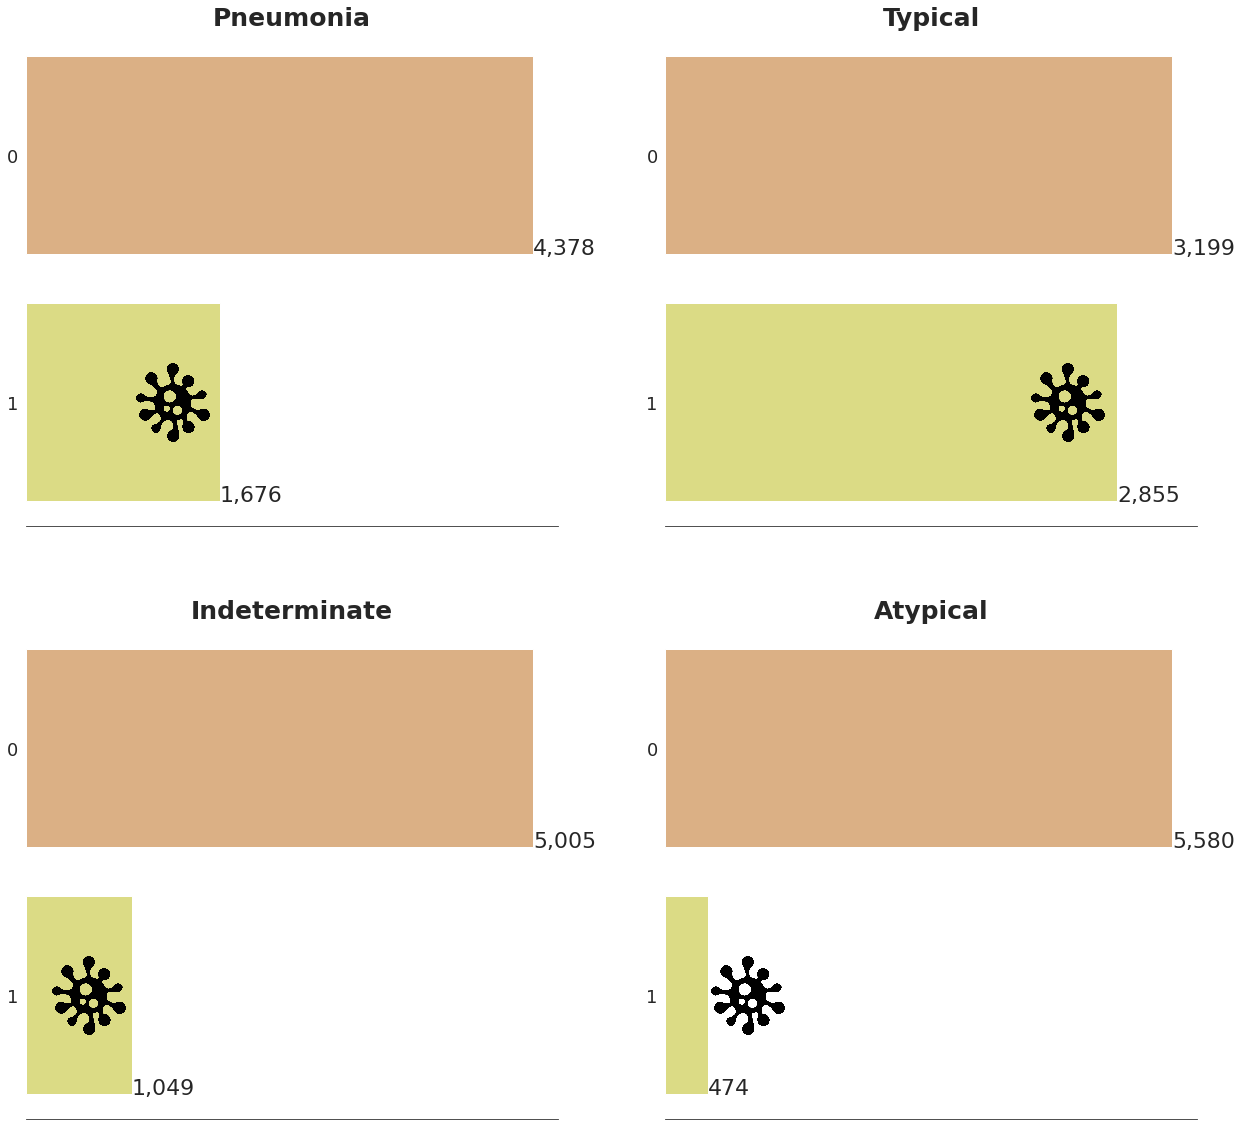

In [8]:
# Process id
train_study["study_id"] = train_study["id"].apply(lambda x: x.split("_")[0])

# Data for plots
pneumonia = train_study["Negative for Pneumonia"]
typical = train_study["Typical Appearance"]
indeterminate = train_study["Indeterminate Appearance"]
atypical = train_study["Atypical Appearance"]

# Plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(21,20))
axs = [ax1, ax2, ax3, ax4]
dfs = [pneumonia, typical, indeterminate, atypical]
titles = ["Pneumonia", "Typical", "Indeterminate", "Atypical"]

for ax, df, title in zip(axs, dfs, titles):
    sns.countplot(y=df, ax=ax, palette=my_colors[1:])
    ax.set_title(title, fontsize=25, weight='bold')
    show_values_on_bars(ax, h_v="h", space=0.4)
    ax.set_xticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    
# Virus png
path='../input/siimfisabiorsna-covid-2021/PinClipart.com_virus-clip-art_742280.png'
offset_png(x=4378, y=1, path=path, ax=ax1, zoom=0.05, offset=-360, border=1)
offset_png(x=2855, y=1, path=path, ax=ax2, zoom=0.05, offset=-50, border=1)
offset_png(x=1049, y=1, path=path, ax=ax3, zoom=0.05, offset=-43, border=1)
offset_png(x=474, y=1, path=path, ax=ax4, zoom=0.05, offset=40, border=1)

In [9]:
# Save plots into W&B Dashboard
for title, df in zip(titles, dfs):
    create_wandb_plot(x_data=[0, 1], 
                      y_data=df.value_counts().values, 
                      x_name="Flag", y_name="Freq", title=title, 
                      log=title, plot="bar")

### How many instances per label?

> 📌 **Note**: 50% of our images have typical appearance. The rest 50% is split in order into *negative for pneumonia* (28%), *indeterminate* (17%) and the rest *atypical*.

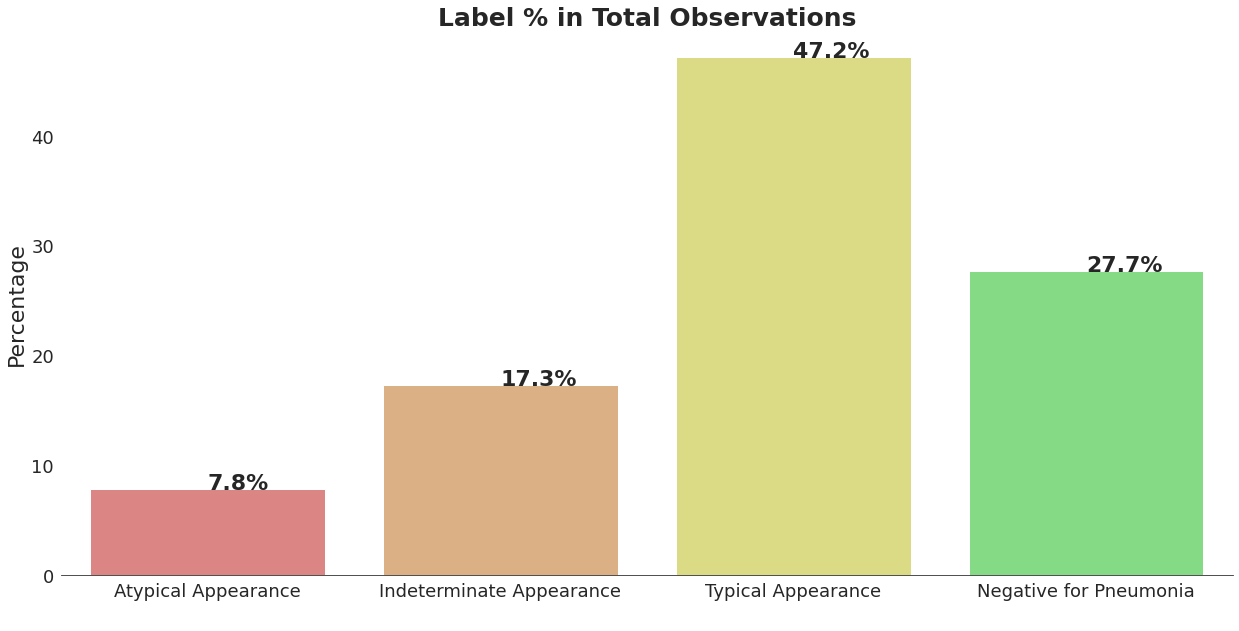

In [10]:
# Get data and transform frequencies to percentages
df = train_study.groupby(['Negative for Pneumonia', 'Typical Appearance',
       'Indeterminate Appearance', 'Atypical Appearance']).count().reset_index()

df["label"] = ['Atypical Appearance', 'Indeterminate Appearance',
               'Typical Appearance', 'Negative for Pneumonia']
df["perc"] = df["id"]/df["id"].sum()*100

# Plot
bar,ax = plt.subplots(figsize=(21,10))
ax = sns.barplot(x=df["label"], y=df["perc"], 
                 ci=None, palette=my_colors, orient='v')
ax.set_title("Label % in Total Observations", fontsize=25,
             weight = "bold")
ax.set_xlabel(" ")
ax.set_ylabel("Percentage")
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width() / 2,rect.get_height(),
             "%.1f%%"% rect.get_height(), weight='bold')

In [11]:
create_wandb_plot(x_data=df["label"].values,
                  y_data=df["perc"].values,
                  x_name="Label", y_name="Percentage", 
                  title="Label % in Total Observations", 
                  log="perc", plot="bar")

In [12]:
wandb.finish()

## 1.2 train_image analysis

🔎 **Findings**:
1. `StudyInstanceUID` corresponds 1:1 to `new_id` created for `train_study`.
2. `image_id` is unique in the `image_train` data.
3. There are images with multiple bounding boxes!
4. There can be multiple images per study!

### How many images have some sort of abnormality?

To have a bounding box we need to have something weird detected in the scan. If there is nothing weird ... then we don't need a bounding box!

In [13]:
run = wandb.init(project='siim-covid19', name='train_imgs_eda', config=CONFIG, anonymous="allow")

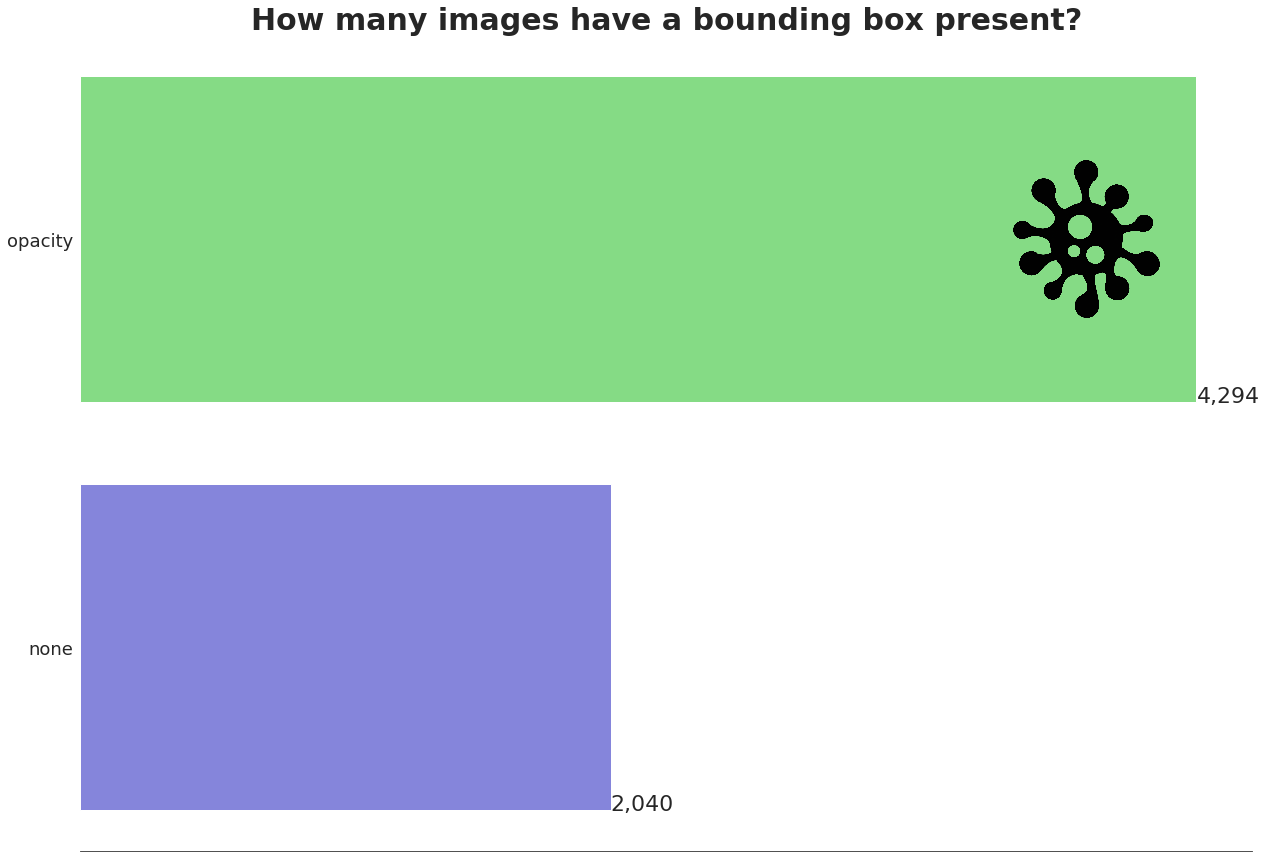

In [14]:
# Process id
train_image["image_id"] = train_image["id"].apply(lambda x: x.split("_")[0])

# Data for plotting
df = train_image["label"].apply(lambda x: x.split(" ")[0]).\
                                    value_counts().reset_index()

# Plot
plt.figure(figsize=(21, 15))
ax = sns.barplot(data=df, y="index", x="label", palette=my_colors[3:])
show_values_on_bars(ax, h_v="h", space=0.4)
plt.title("How many images have a bounding box present?", 
          fontsize=30, weight='bold')
plt.xticks([])
plt.ylabel('')
plt.xlabel('');

# Virus png
path='../input/siimfisabiorsna-covid-2021/PinClipart.com_virus-clip-art_742280.png'
offset_png(x=4294, y=0, path=path, ax=ax, zoom=0.1, offset=-110, border=1)

In [15]:
create_wandb_plot(x_data=df["index"], 
                  y_data=df["label"].values, 
                  x_name="BBox", y_name="Freq", 
                  title="Images with bbox",
                  log="bbox", plot="bar")

### How many images per each study?

> Majority of studies have only 1 images. That being said, we have ~230 studies that have multiple images available (up to 9).

Max number of images available per study: 9 
Min number of images available per study: 1 




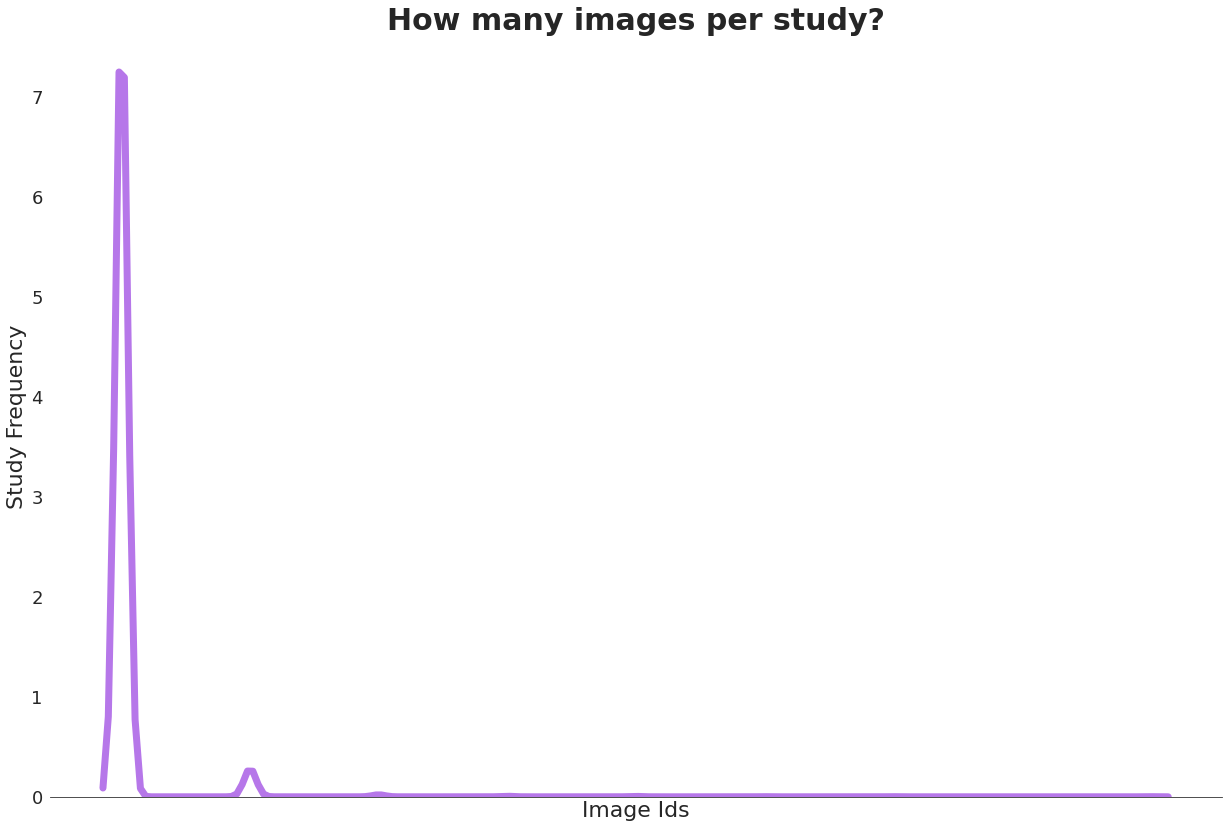

In [16]:
# Crate df
df = train_image["StudyInstanceUID"].value_counts().reset_index().\
                        sort_values("StudyInstanceUID", ascending=False)
print(color.BOLD + "Max number of images available per study:" + color.END, 
      df["StudyInstanceUID"].max(), "\n" +
      color.BOLD + "Min number of images available per study:" + color.END, 
      df["StudyInstanceUID"].min(), 2*"\n")
# Plot
plt.figure(figsize=(21, 14))
sns.distplot(a=df["StudyInstanceUID"], color=my_colors[6], 
             hist=False, kde_kws=dict(lw=7, ls="-"))
plt.title("How many images per study?", 
          fontsize=30, weight='bold')
plt.xticks([])
plt.ylabel('Study Frequency')
plt.xlabel('Image Ids');

In [17]:
wandb.log({"max_images_on_study" : df["StudyInstanceUID"].max()})
create_wandb_hist(x_data=df["StudyInstanceUID"], 
                  x_name="Image Freq", title="No. images per study", 
                  log="hist")

In [18]:
wandb.finish()

> After EDA, my [W&B Dashboard](https://wandb.ai/andrada/siim-covid19?workspace=user-andrada) looks like this:

<center><img src="https://i.imgur.com/HQBdtSd.gif" width=600></center>

### Create the full train dataset

This is also how the `final_label` will need to look before submission.

<center><img src="https://i.imgur.com/8Ckg1L0.png" width=600></center>

In [19]:
# Merge all info together
train = pd.merge(train_image, train_study, 
                 left_on="StudyInstanceUID", right_on="study_id")

train.drop(["id_x", "StudyInstanceUID", "id_y"], axis=1, inplace=True)

> Let's also look at the study id `0fd2db233deb`, which has most of the images available. 8 images have nothing unusual in them and 1 is labeled as `Indeterminate Appearance`.

In [20]:
train[train["study_id"] == "0fd2db233deb"]

,boxes,label,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,study_id
137,NaN,none 1 0 0 1 1,04cc2f7f4c4b,0,0,1,0,0fd2db233deb
138,NaN,none 1 0 0 1 1,05c063f5cef5,0,0,1,0,0fd2db233deb
139,NaN,none 1 0 0 1 1,156cb1f5c689,0,0,1,0,0fd2db233deb
140,"[{'x': 561.30269, 'y': 163.28797, 'width': 883...",opacity 1 561.30269 163.28797 1445.02377 1495....,26f643772090,0,0,1,0,0fd2db233deb
141,NaN,none 1 0 0 1 1,4c414b793562,0,0,1,0,0fd2db233deb
142,NaN,none 1 0 0 1 1,a5a364383f34,0,0,1,0,0fd2db233deb
143,NaN,none 1 0 0 1 1,b121806162c3,0,0,1,0,0fd2db233deb
144,NaN,none 1 0 0 1 1,bee62c601ae9,0,0,1,0,0fd2db233deb
145,NaN,none 1 0 0 1 1,c6e92e59a0ae,0,0,1,0,0fd2db233deb


# 2. 📷 Images

Good, now that we've explored the metadata and the `target` labels, we can start focusing on the good stuff - meaning the **CT scans**.

<center><img src="https://i.imgur.com/DFDDdvD.png" width=550></center>

### WHAT ARE CT SCANS?

"A **Computerized Tomography** scan (CT or CAT scan) uses computers and rotating X-ray machines to **create cross-sectional images** of the body. These images provide **more detailed** information than normal X-ray images. They can show the **soft tissues**, **blood vessels**, and **bones** in various parts of the body."

<center><img src="https://i.imgur.com/5WUxAHZ.png" width=550></center>

In [21]:
run = wandb.init(project='siim-covid19', name='image_explore', config=CONFIG, anonymous="allow")

In [22]:
def show_dcm_info(study_ids, df):
    '''Show .dcm images along with description.'''
    wandb_logs = []
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(21,10))

    # Get .dcm paths
    dcm_paths = [glob.glob(f"../input/siim-covid19-detection/train/{study_id}/*/*")[0]
                 for study_id in study_ids]
    datasets = [pydicom.dcmread(path) for path in dcm_paths]
    images = [apply_voi_lut(dataset.pixel_array, dataset) for dataset in datasets]

    # Loop through the information
    for study_id, data, img, i in zip(study_ids, datasets, images, range(2*3)):
        # Fix inverted images
        img = fix_inverted_radiograms(data, img)

        # Below function available in functions section ;)
        label, bbox = get_image_metadata(study_id, df)
        
        # Check for bounding box and add if it's the case
        try: 
            # For no bbox, the list is [nan]
            no_box = math.isnan(bbox[0])
            pass
        except TypeError:
            # Retrieve the bounding box
            all_coords = []
            for box in bbox:
                all_coords.append(return_coords(box))

            for (x1, y1, x2, y2) in all_coords:
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 80, 255), 15)
                cv2.putText(img, label, (x1, y1-14), 
                            cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 0), 4)
                
        # Plot the image
        x = i // 3
        y = i % 3
        
        axes[x, y].imshow(img, cmap="rainbow")
        axes[x, y].set_title(f"Label: {label} \n Sex: {data.PatientSex} | Body Part: {data.BodyPartExamined}", 
                  fontsize=14, weight='bold')
        axes[x, y].axis('off');
        
        # Save to W&B
        wandb_logs.append(wandb.Image(img, 
                                      caption=f"Label: {label} \n Sex: {data.PatientSex} | Body Part: {data.BodyPartExamined}"))
          
    wandb.log({f"{label}": wandb_logs})

### Typical Appearance

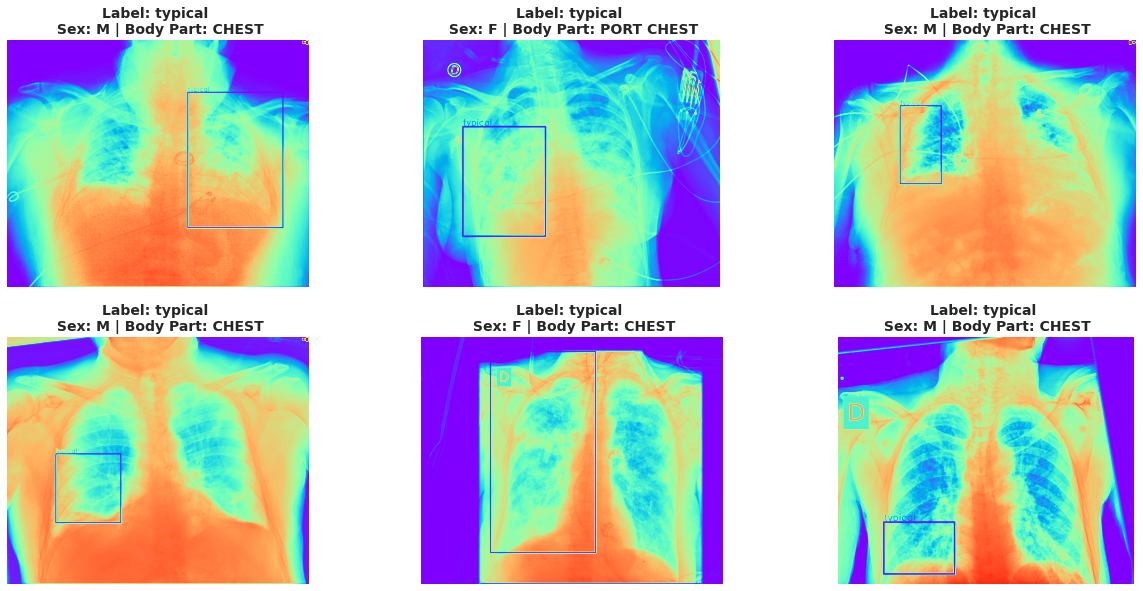

In [23]:
show_dcm_info(study_ids=["72044bb44d41", "5b65a69885b6", "6aa32e76f998",
                         "c9ffe6312921", "082cafb03942", "d3e83031ebea"], 
              df=train)

### Atypical Appearance

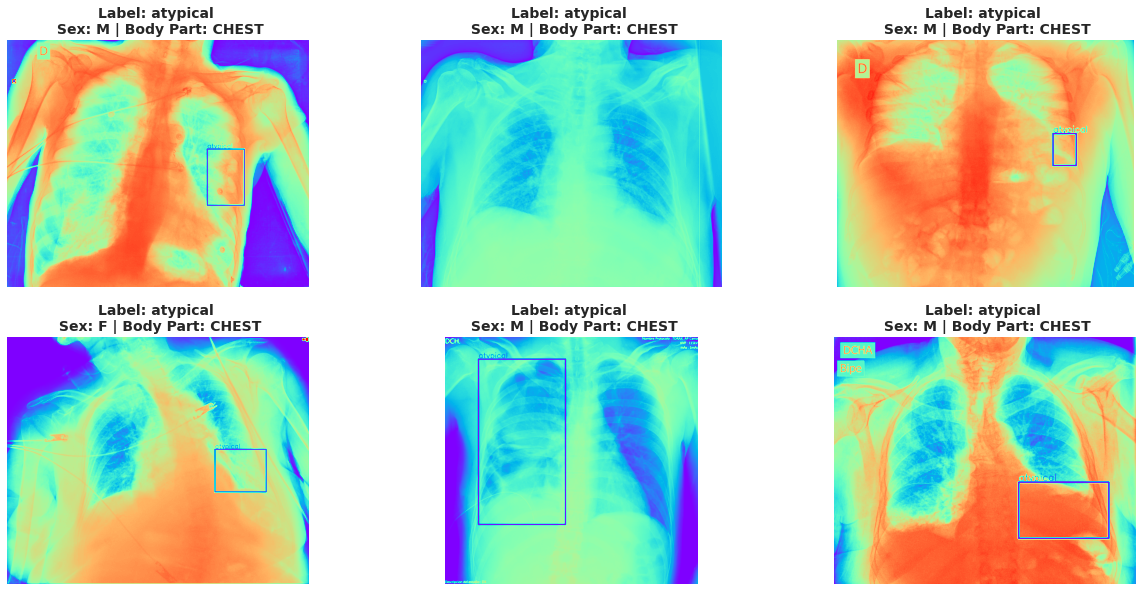

In [24]:
show_dcm_info(study_ids=["f807cd855d31", "8087e3bc0efe", "7249de10ed69",
                         "e300a4e86207", "4bac6c7da8b8", "f2d30ac37f7b"], 
              df=train)

### Indeterminate Appearance

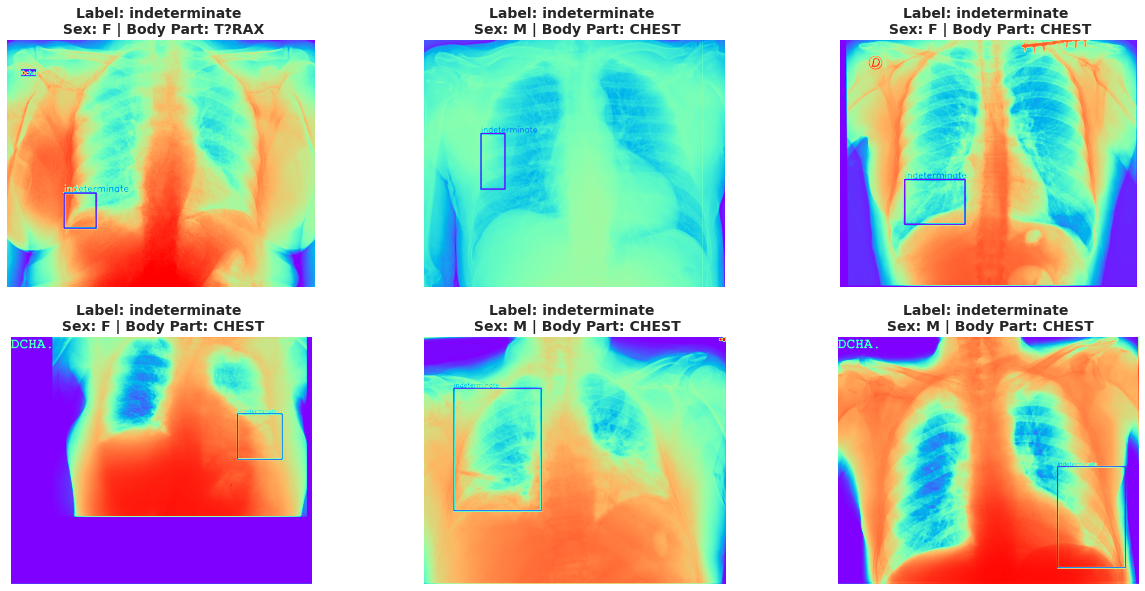

In [25]:
show_dcm_info(study_ids=["b949689a9ef1", "fe7e6015560d", "feffa20fac13",
                         "747483509d0e", "c70369caef91", "1e1b4b1b53cb"], 
              df=train)

### Negative for Pneumonia

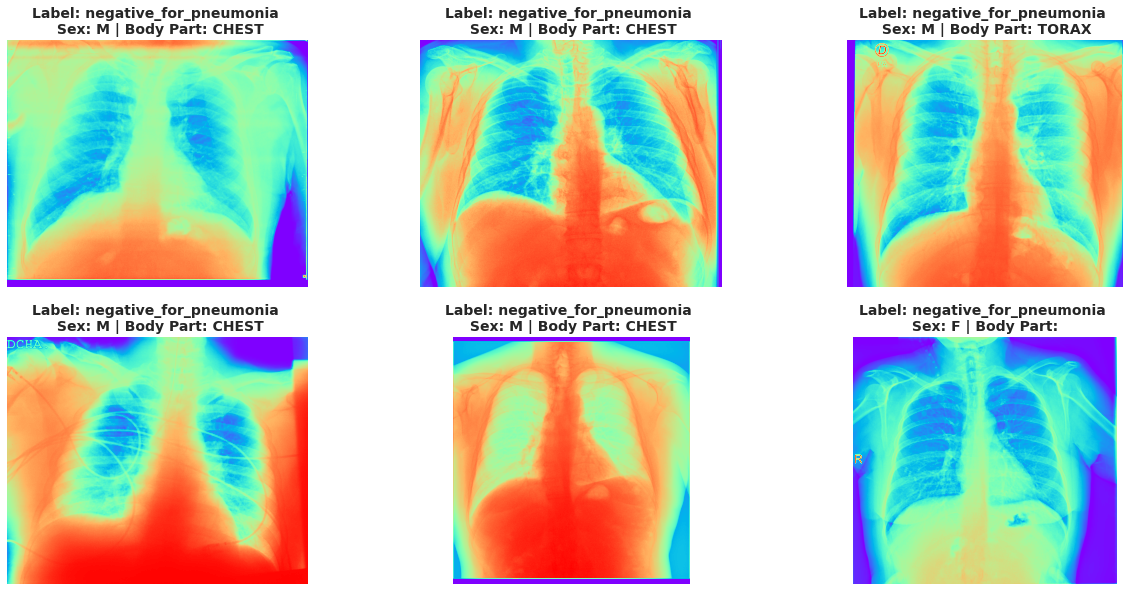

In [26]:
show_dcm_info(study_ids=["612ea5194007", "db14e640e037", "d4ab797396b4",
                         "6ae8a88c4b0c", "b3cf474bee3b", "0ba55e5422ab"], 
              df=train)

## 2.2 Magic - save images & bounding boxes to W&B

> 🔗 **Thank you very much to Ayush**, who inspired the following experiment. :) You can find [his full notebook with explanations here](https://www.kaggle.com/ayuraj/visualize-bounding-boxes-interactively).

In [27]:
def wandb_bbox(image, bboxes, true_label, class_id_to_label):
    '''Source: https://www.kaggle.com/ayuraj/visualize-bounding-boxes-interactively
    Thank you Ayush for all your hard work! ^^'''
    all_boxes = []
    for bbox in bboxes:
        box_data = {"position": {
                        "minX": bbox[0],
                        "minY": bbox[1],
                        "maxX": bbox[2],
                        "maxY": bbox[3]
                    },
                     "class_id" : int(true_label),
                     "box_caption": class_id_to_label[true_label],
                     "domain" : "pixel"}
        all_boxes.append(box_data)
    

    return wandb.Image(image, boxes={
        "ground_truth": {
            "box_data": all_boxes,
          "class_labels": class_id_to_label
        }
    })


def resize_img_and_coord(img, coord, resize):
    '''Resizes the image and its coordinates.
    img: the pixel.array image
    coord: the speciffic coordinates from return_coordinates() function
    resize: and integer specifying the desired size of new image'''
    
    # Resize the image
    w_old, h_old = img.shape

    # Resize the coordinates
    img = cv2.resize(img, (resize,resize))

    new_x1 = int(coord[0][0] / (w_old/resize))
    new_y1 = int(coord[0][1] / (h_old/resize))
    new_x2 = int(coord[0][2] / (w_old/resize))
    new_y2 = int(coord[0][3] / (h_old/resize))
    new_coord = [(new_x1, new_y1, new_x2, new_y2)]
    
    return img, new_coord

Let's look at an **example of 10 images** (below you can see how all the code outputs in the [W&B Dashboard](https://wandb.ai/andrada/siim-covid19?workspace=user-andrada)!)
<center><video src="https://i.imgur.com/q0jCbza.mp4" width=650 controls></center>

In [28]:
# Get a few example ids (image_id)
example_ids = ["000a312787f2", "0012ff7358bc", "001398f4ff4f",
               "001bd15d1891", "002e9b2128d0", "ffbeafe30b77",
               "0022227f5adf", "00a129830f4e", "01376c1ba556", "008ca392cff3"]

# Read in datas
study_ids = train[train["image_id"].isin(example_ids)]["study_id"].values
paths = [glob.glob(f"../input/siim-covid19-detection/train/{i}/*/*")[0]
         for i in study_ids]

# Retrieve resized information
images, coords, labels = [], [], []
for path, study_id in zip(paths, study_ids):
    try:
        # Read data file
        data = pydicom.dcmread(path)
        # Get image data
        img = apply_voi_lut(data.pixel_array, data)
        # Get image coordinates
        label, bbox = get_image_metadata(study_id=study_id, df=train)
        coord = [return_coords(box) for box in bbox]

        # Fix inverted radiograms + resize
        img = fix_inverted_radiograms(data, img)
        resized_img, resized_coord = resize_img_and_coord(img, coord, resize=200)

        images.append(resized_img)
        coords.append(resized_coord)
        labels.append(label)
    except RuntimeError:
        pass

In [29]:
# Map each label to a number
class_label_to_id = {'atypical': 0, 'indeterminate': 1, 'typical': 2}
# And each number to a label
class_id_to_label = {val: key for key, val in class_label_to_id.items()}

# Log each image
wandb_bbox_list = []

for image, coord, label in zip(images, coords, labels):
    wandb_bbox_list.append(wandb_bbox(image=image,
                                      bboxes=coord, 
                                      true_label=class_label_to_id[label],
                                      class_id_to_label=class_id_to_label))

# Save images to W&B Dashboard
wandb.log({"radiograph": wandb_bbox_list})

print(color.BOLD + "Finished! Your Images were uploaded in your W&B Dashboard!" + color.END)

Finished! Your Images were uploaded in your W&B Dashboard!


In [30]:
wandb.finish()

# 3. Extract Metadata from .dcm

> 📌 **Important**: We can create *more* **metadata** (more information on the images) from the information stored in the `.dcm` files. Below I am extracting all features stored in each `.dcm` file and storing them into a sepparate dataframe.

## 3.1 Store and Save Metadata

<center><img src="https://i.imgur.com/8Fhupoe.png" width=650></center>

In [31]:
def get_observation_data(path):
    """Get information from the .dcm files.
    path: complete path to the .dcm file"""

    image_data = pydicom.read_file(path)
    
    # Dictionary to store the information from the image
    observation_data = {
        "FileNumber" : path.split("/")[5],
        "Rows" : image_data.get("Rows"),
        "Columns" : image_data.get("Columns"),
        "PatientID" : image_data.get("PatientID"),
        "PatientName" : image_data.get("PatientName"),
        "PhotometricInterpretation" : image_data.get("PhotometricInterpretation"),
        "StudyInstanceUID" : image_data.get("StudyInstanceUID"),
        "SamplesPerPixel" : image_data.get("SamplesPerPixel"),
        "BitsAllocated" : image_data.get("BitsAllocated"),
        "BitsStored" : image_data.get("BitsStored"),
        "HighBit" : image_data.get("HighBit"),
        "PixelRepresentation" : image_data.get("PixelRepresentation"),
    }

    # String columns
    str_columns = ["ImageType", "Modality", "PatientSex", "BodyPartExamined"]
    for k in str_columns:
        observation_data[k] = str(image_data.get(k)) if k in image_data else None

    
    return observation_data

In [32]:
# # An example
# p = "../input/siim-covid19-detection/train/00792b5c8852/1f52bcb3143e/3fadf4b48db3.dcm"
# example = get_observation_data(p)
# print(example)

# # === GET ALL METADATA ===
# # Get all paths to .dcm files
# all_paths = glob.glob("../input/siim-covid19-detection/train/*/*/*")

# # === Get metadata ===
# exceptions = 0
# dicts = []

# for path in tqdm.tqdm(all_paths):
#     # Get .dcm metadata
#     ### TODO: add .dcm id
#     try:
#         d = get_observation_data(path)
#         dicts.append(d)
#     except Exception as e:
#         exceptions += 1
#         continue
        
# # === SAVE METADATA ===
# # Convert into df
# meta_train_data = pd.DataFrame(data=dicts, columns=example.keys())
# meta_train_data[""]
# # Export information
# meta_train_data.to_csv("meta_train.csv", index=False)

# print("Metadata processed & saved successfuly :)")

## 3.2 Let's Analyse the new information

In [33]:
# Save data to W&B Dashboard
save_dataset_artifact(run_name='dave-dcm-meta',
                      artifact_name='dcm_metadata', 
                      path="../input/siimfisabiorsna-covid-2021/meta_train.csv")

Artifact has been saved successfully.


In [34]:
# Import
dcm_meta = pd.read_csv("../input/siimfisabiorsna-covid-2021/meta_train.csv")
dcm_meta = pd.concat([dcm_meta, train], axis=1)

dcm_meta.head(2)

,FileNumber,Rows,Columns,PatientID,PatientName,PhotometricInterpretation,StudyInstanceUID,SamplesPerPixel,BitsAllocated,BitsStored,...,PatientSex,BodyPartExamined,boxes,label,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,study_id
0,b2ee36aa2df5,2336,2836,cc5e0ad1a536,1df0304624f5,MONOCHROME1,cd5dd5e6f3f5,1,16,15,...,M,CHEST,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,000a312787f2,0,1,0,0,5776db0cec75
1,60a49211f5df,3488,4256,3c6db652d71e,c3392f06a401,MONOCHROME2,49358afcfb80,1,16,12,...,M,CHEST,NaN,none 1 0 0 1 1,000c3a3f293f,1,0,0,0,ff0879eb20ed


### Patient's Gender

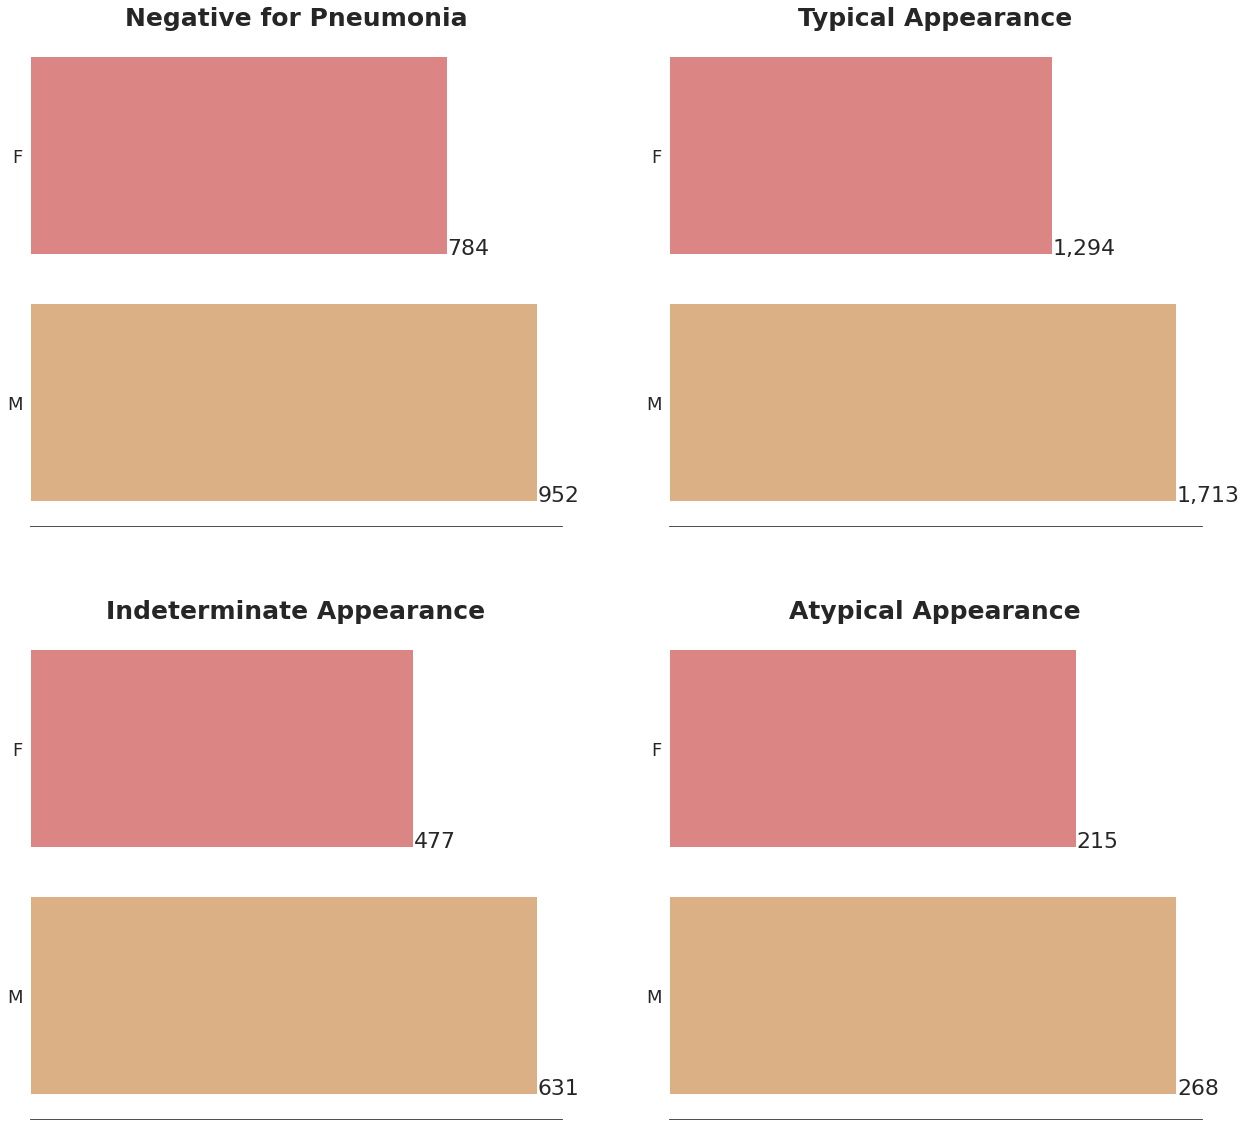

In [35]:
# Get the Data
labels = ['Negative for Pneumonia', 'Typical Appearance', 
          'Indeterminate Appearance', 'Atypical Appearance']
dt = dcm_meta.groupby("PatientSex")[labels].sum().reset_index()

# Plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(21,20))
axs = [ax1, ax2, ax3, ax4]

for ax, title in zip(axs, labels):
    sns.barplot(data=dt, x=title, y="PatientSex", 
                ax=ax, palette=my_colors[0:])
    ax.set_title(title, fontsize=25, weight='bold')
    show_values_on_bars(ax, h_v="h", space=0.4)
    ax.set_xticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')

### Location of X-rays

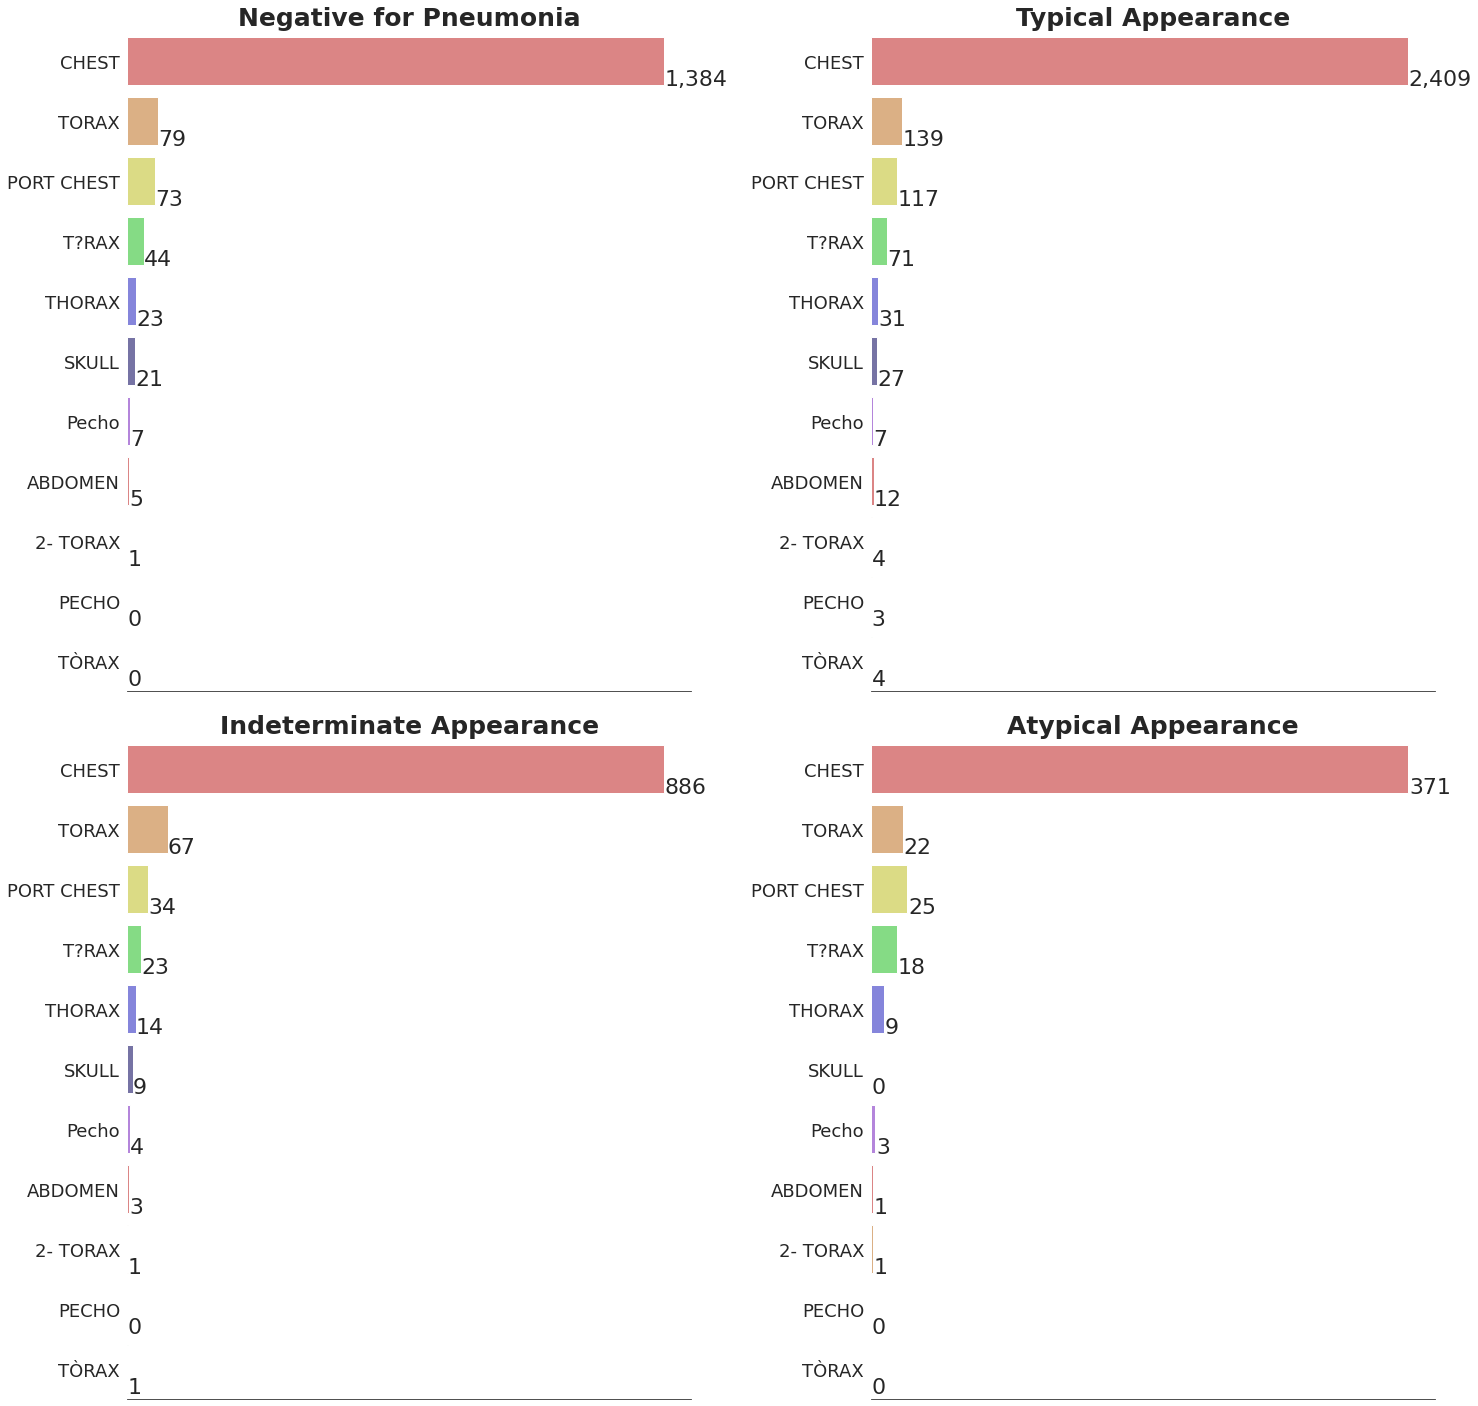

In [36]:
# Get the Data
labels = ['Negative for Pneumonia', 'Typical Appearance', 
          'Indeterminate Appearance', 'Atypical Appearance']
dt = dcm_meta.groupby("BodyPartExamined")[labels].sum().reset_index()
dt = dt.sort_values("Negative for Pneumonia", ascending=False)

# Plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(21,20))
axs = [ax1, ax2, ax3, ax4]

for ax, title in zip(axs, labels):
    sns.barplot(data=dt, x=title, y="BodyPartExamined", 
                ax=ax, palette=my_colors)
    ax.set_title(title, fontsize=25, weight='bold')
    show_values_on_bars(ax, h_v="h", space=0.4)
    ax.set_xticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    fig.tight_layout()

### MONOCHROME1 or MONOCHROME2? That's the question ...

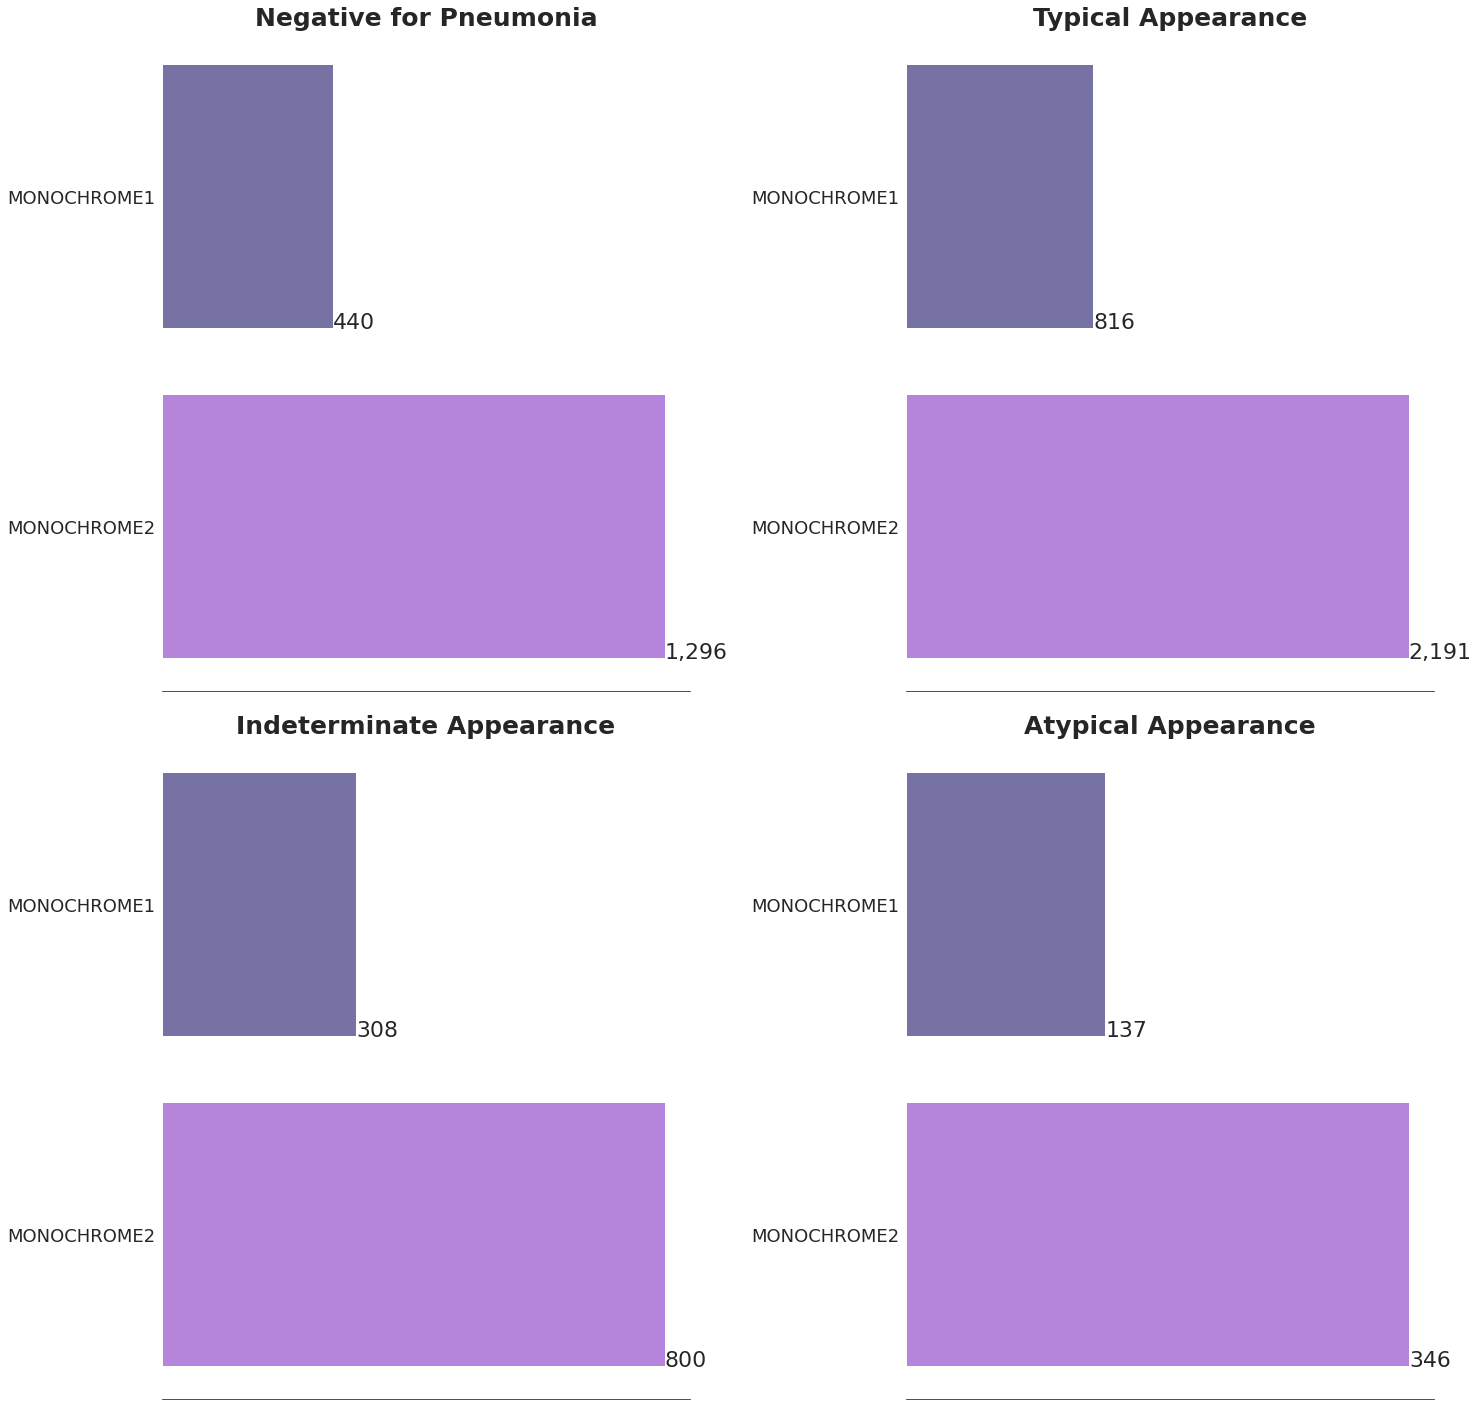

In [37]:
# Get the Data
labels = ['Negative for Pneumonia', 'Typical Appearance', 
          'Indeterminate Appearance', 'Atypical Appearance']
dt = dcm_meta.groupby("PhotometricInterpretation")[labels].sum().reset_index()

# Plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(21,20))
axs = [ax1, ax2, ax3, ax4]

for ax, title in zip(axs, labels):
    sns.barplot(data=dt, x=title, y="PhotometricInterpretation", 
                ax=ax, palette=my_colors[5:])
    ax.set_title(title, fontsize=25, weight='bold')
    show_values_on_bars(ax, h_v="h", space=0.4)
    ax.set_xticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    fig.tight_layout()

> The Exploratory Dashboard in W&B!
<center><video src="https://i.imgur.com/P8tdXpU.mp4" width=650 controls></center>

<center><img src="https://i.imgur.com/cUQXtS7.png"></center>

# ⌨️🎨 My Specs

* **Z8 G4** Workstation 🖥
* 2 CPUs & 96GB Memory 💾
* NVIDIA **Quadro RTX 8000** 🎮
* **RAPIDS** version 0.17 🏃🏾•♀️